# Figures: MELD NeurIPS 2019 Fourier Ptychography Example

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os, sys
import argparse
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from datetime import datetime

# MELD toolbox
import meld.recon as recon

# import local experiment files
sys.path.append('../')
import dataloader
import visualizer
import model

In [3]:
# Setup device
device_no = 1
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

14596.776384920633
(512, 512, 293)
(293, 2)
0.2 0.514 0.8125
Bright Field: 21
Dark Field: 68
Total LEDs: 89


<IPython.core.display.Javascript object>


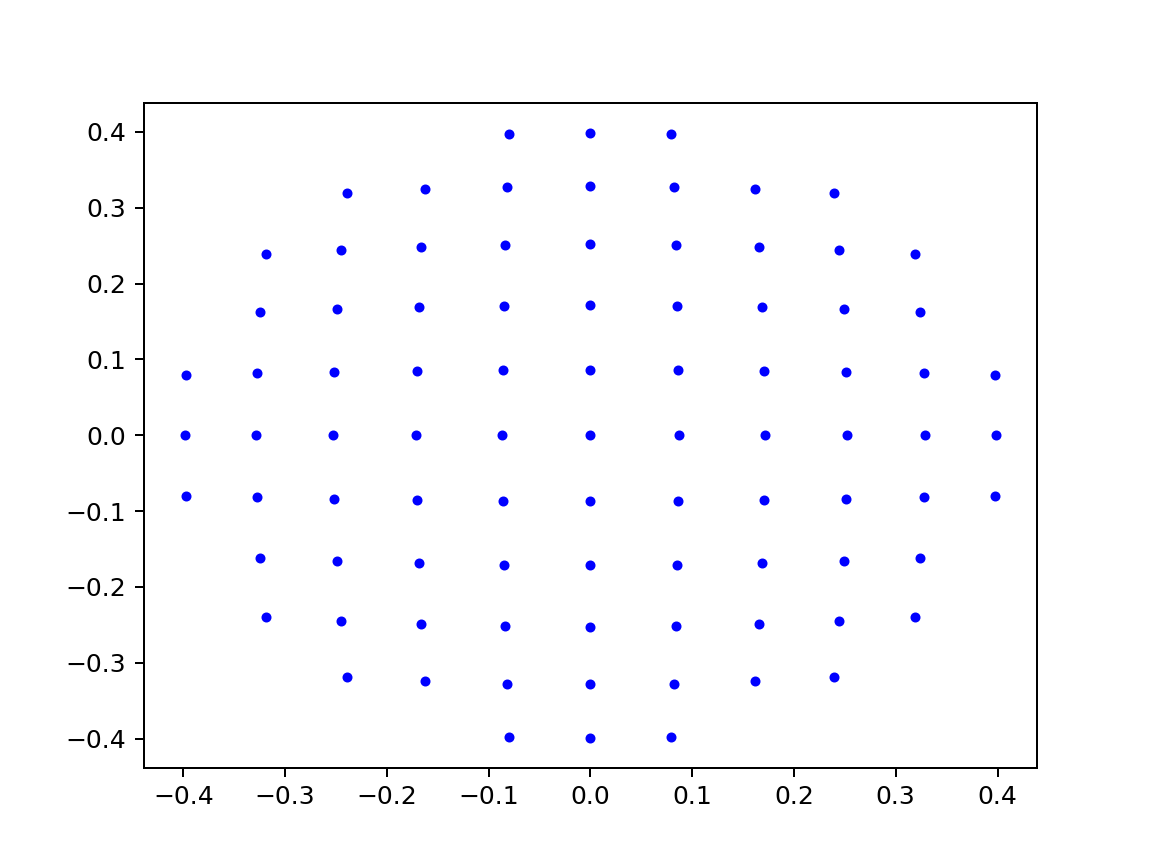

In [4]:
import scipy.io as sio
loaddict = sio.loadmat('../../../../DATA/exp_mc_amp_usaf_2018_11_23/USAF_amplitude_dataset.mat')
img_list = loaddict['I']
bg = np.mean(img_list[415:450,70:100,0])
print(bg)

np_dtype = np.float32
img_list = (img_list/bg).astype(np_dtype)
print(img_list.shape)

# (optional) add more noise to improvement regularization
# noise = np.random.normal(img_list).astype(np_dtype)

# na_list = np.asarray([loaddict['na_x_list'][0],loaddict['na_y_list'][0]]).transpose()
na_list = np.asarray([loaddict['na_y_list'][0],loaddict['na_x_list'][0]]).transpose()
print(na_list.shape)
na = loaddict['sys_na'][0][0]
wl = loaddict['wavelength'][0][0]
ps = loaddict['pixel_size'][0][0]
Nleds = na_list.shape[0]
print(na,wl,ps)

Np = [250,250] # will determine how much to crop out based on upsampling ratio

def dist2(nalist):
    return np.sqrt((nalist[:,0])**2 + (nalist[:,1])**2)
distlist = dist2(na_list)

bfmask = distlist < na
bfleds = na_list[bfmask,:]
Nbfleds = np.sum(bfmask)
print('Bright Field:',np.sum(bfmask))

na_illum = 2.1 * na
dfmask = (distlist < na_illum) & (distlist > na)
dfleds = na_list[dfmask,:]
Ndfleds = np.sum(dfmask)
print('Dark Field:',np.sum(dfmask))

Nleds = Nbfleds + Ndfleds
print('Total LEDs:',Nleds)
pruned_na_list = na_list[:Nleds,:]

plt.figure()
plt.plot(pruned_na_list[:,0],pruned_na_list[:,1],'b.')

In [5]:
# load dataset and metadata
path = '/home/kellman/Workspace/PYTHON/Design_FPM_pytorch/datasets_train_iccp_results/train_amp_exp_n10000.mat' 
dataset = dataloader.dataloader(path, 1, 1, device)
metadata = dataset.getMetadata()

# model checkpoint
ckpt_path = '../runs/09:54:31_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.100_num_meas=6_num_leds=89_meld=False/ckpt.tar'
checkpoint = torch.load(ckpt_path)

metadata['Np'] = Np
metadata['num_bf'] = checkpoint['num_bf']
metadata['num_df'] = checkpoint['num_df']
metadata['num_unrolls'] = checkpoint['num_unrolls']
metadata['alpha'] = checkpoint['alpha']
metadata['T'] = 4
metadata['mag'] *= 2 # allow for 2x on sideport...
network = model.model(metadata, device=device)
print(metadata['ps'], metadata['mag'], metadata['na'])

Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 0.8125
6.5 8 0.2


In [6]:
# setup measurements
crop = network.grad.crops
scaling = network.grad.scaling
print(crop,scaling)

def padMeas(meas,crop):
    padded = np.zeros((meas.shape[0],Np[0],Np[1]))
    cftmp = np.zeros(Np,dtype='complex')
    for ii in range(meas.shape[0]):
        ftmp = np.fft.fftshift(np.fft.fft2(meas[ii,:,:]))
        cftmp[crop[0]:crop[1],crop[2]:crop[3]] = ftmp
        padded[ii,:,:] = np.fft.ifft2(np.fft.ifftshift(cftmp))
    return scaling * padded

Np_meas = img_list.shape[:2]
print(Np_meas)
Nstart = [210-crop[0],180-crop[2]] # whole crop (paper)
crop_list = img_list[Nstart[0] + crop[0]:Nstart[0] + crop[1], Nstart[1] + crop[2]:Nstart[1] + crop[3],:].transpose((2,0,1))
print(crop_list.shape)
up_img_list = padMeas(crop_list,crop)
up_img_list = up_img_list[:Nleds,:,:]
print(up_img_list.shape)

[61, 189, 61, 189] 3.814697265625
(512, 512)
(293, 128, 128)


/home/kellman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


(89, 250, 250)


<IPython.core.display.Javascript object>


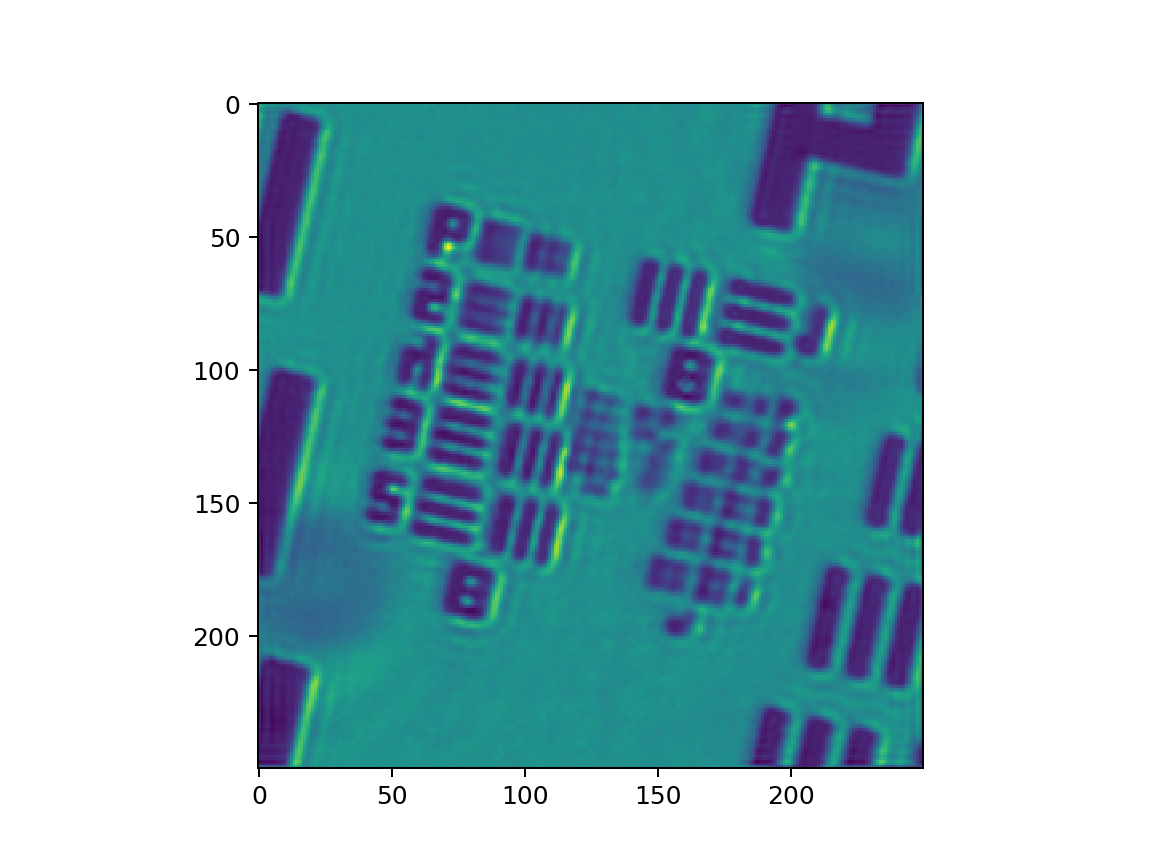

In [7]:
plt.figure()
plt.imshow(up_img_list[0,:,:])

# Learned Illumination (Backpropagation) Reconstruction

In [8]:
# model checkpoint
ckpt_path = '../runs/09:54:31_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.100_num_meas=6_num_leds=89_meld=False/ckpt.tar'
ckpt_path = '../runs/10:31:27_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.200_num_meas=6_num_leds=89_meld=False/ckpt.tar'
ckpt_path = '../runs/11:14:25_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.500_num_df=9_num_bf=1_num_leds=89_meld=False/ckpt.tar'
ckpt_path = '../runs/16:37:02_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.400_num_df=7_num_bf=1_num_leds=89_meld=False/ckpt.tar'
ckpt_path = '../runs/11:00:29_batch_size=5_stepsize=0.003_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.400_num_df=7_num_bf=1_num_leds=89_meld=False/ckpt.tar'

checkpoint = torch.load(ckpt_path)

metadata['Np'] = Np
metadata['num_bf'] = checkpoint['num_bf']
metadata['num_df'] = checkpoint['num_df']
metadata['num_unrolls'] = checkpoint['num_unrolls']
metadata['alpha'] = checkpoint['alpha']
print(metadata['alpha'], metadata['num_unrolls'])
metadata['T'] = 4
metadata['mag'] *= 2 # allow for 2x on sideport...
network = model.model(metadata, device=device)

tag = next(reversed(checkpoint['model_state_dict']))
Ctrained = checkpoint['model_state_dict'][tag]
network.grad.C.data = Ctrained.to(device)

0.4 100
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 0.40625


In [9]:
input_data = torch.unsqueeze(torch.from_numpy(up_img_list.astype(np_dtype)),0)
x0 = network.initialize(input_data.to(device), device=device)
trainable_network = recon.UnrolledNetwork(network.network, 
                                    x0, 
                                    memlimit=np.infty, 
                                    loss=None,
                                    device=device)
with torch.no_grad():
    x_bp, _, _ = trainable_network.evaluate(x0)

Memory per iteration: 2552.0 MB
Total memory: 255200.0 MB


<IPython.core.display.Javascript object>


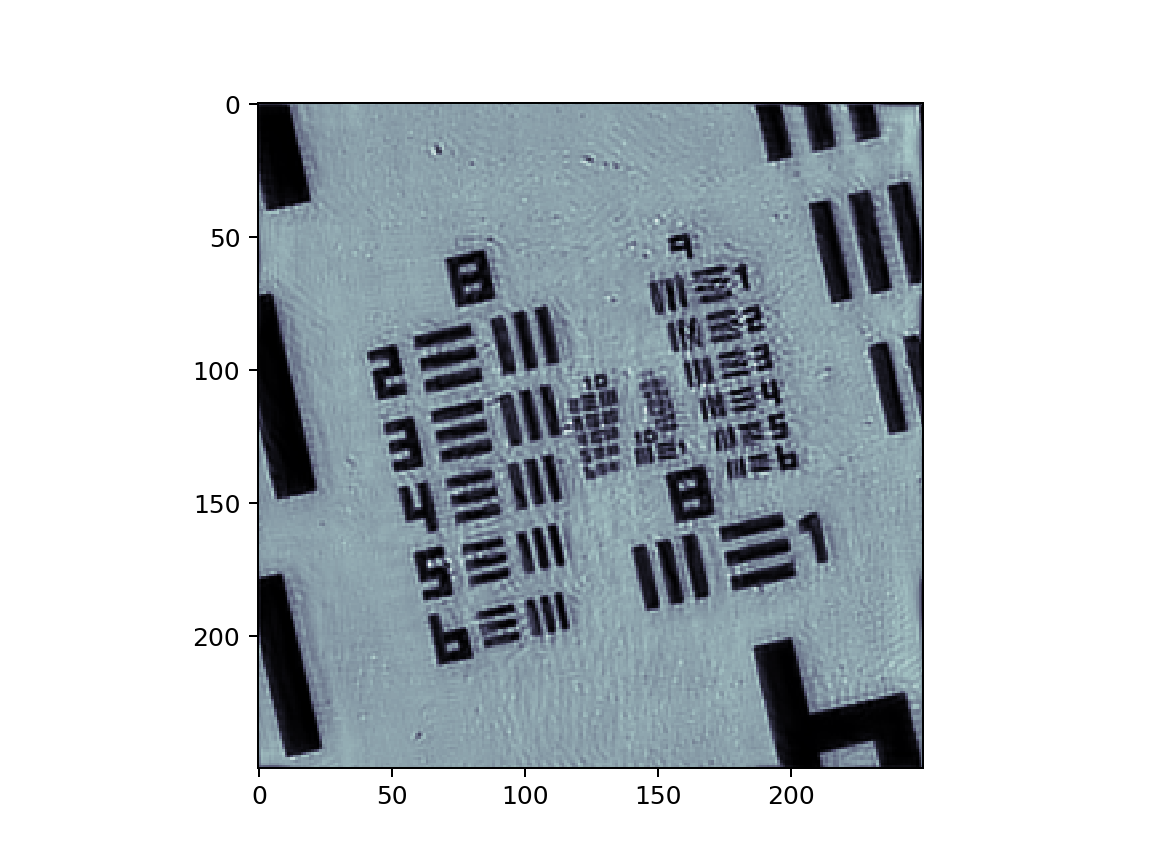

In [10]:
x_bp_abs = x_bp[...,0]**2 + x_bp[...,1]**2
x_bp_abs_np = x_bp_abs.cpu().numpy()
view = lambda x : x[::-1]
plt.figure()
plt.imshow(view(x_bp_abs_np),cmap='bone')

# Learned Illumination (MELD) Reconstruction

In [11]:
# model checkpoint
ckpt_path = '../runs/09:55:05_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.100_num_meas=6_num_leds=89_meld=True/ckpt.tar'
ckpt_path = '../runs/10:46:25_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.200_num_meas=6_num_leds=89_meld=True/ckpt.tar'
ckpt_path = '../runs/11:21:58_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.500_num_df=9_num_bf=1_num_leds=89_meld=True/ckpt.tar'
ckpt_path = '../runs/16:36:52_batch_size=5_stepsize=0.010_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.400_num_df=7_num_bf=1_num_leds=89_meld=True/ckpt.tar'
ckpt_path = '../runs/11:00:55_batch_size=5_stepsize=0.003_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.400_num_df=7_num_bf=1_num_leds=89_meld=True/ckpt.tar'

checkpoint = torch.load(ckpt_path)

metadata['Np'] = Np
metadata['num_bf'] = checkpoint['num_bf']
metadata['num_df'] = checkpoint['num_df']
metadata['num_unrolls'] = checkpoint['num_unrolls']
metadata['alpha'] = checkpoint['alpha']
metadata['T'] = 4
metadata['mag'] *= 2 # allow for 2x on sideport...
network = model.model(metadata, device=device)

tag = next(reversed(checkpoint['model_state_dict']))
Ctrained = checkpoint['model_state_dict'][tag]
network.grad.C.data = Ctrained.to(device)

Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 0.203125


In [12]:
input_data = torch.unsqueeze(torch.from_numpy(up_img_list.astype(np_dtype)),0)
x0 = network.initialize(input_data.to(device), device=device)
print(x0.shape)
trainable_network = recon.UnrolledNetwork(network.network, 
                                    x0, 
                                    memlimit=np.infty, 
                                    loss=None,
                                    device=device)
with torch.no_grad():
    x_meld, _, _ = trainable_network.evaluate(x0)

torch.Size([250, 250, 2])
Memory per iteration: 2552.0 MB
Total memory: 255200.0 MB


<IPython.core.display.Javascript object>


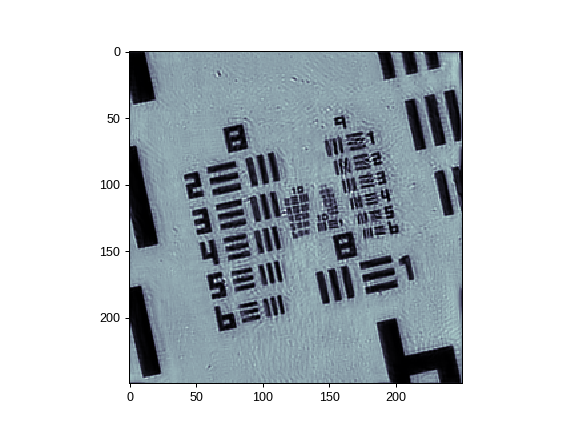

In [13]:
x_meld_abs = x_meld[...,0]**2 + x_meld[...,1]**2
x_meld_abs_np = x_meld_abs.cpu().numpy()
view = lambda x : x[::-1]
plt.figure()
plt.imshow(view(x_meld_abs_np),cmap='bone')

# Single LED Reconstruction

<IPython.core.display.Javascript object>


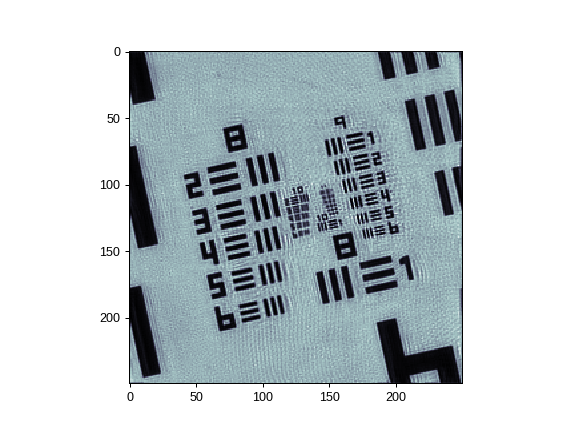

In [14]:
# just load reconstruction... Takes fucking forever on GPU
x_single = sio.loadmat('./full_single_led_reconstruction.mat')['x']
x_single_abs = x_single[...,0]**2 + x_single[...,1]**2
view = lambda x : x[::-1]
plt.figure()
plt.imshow(view(x_single_abs),cmap='bone')

# Reconstruction Visualization

<IPython.core.display.Javascript object>


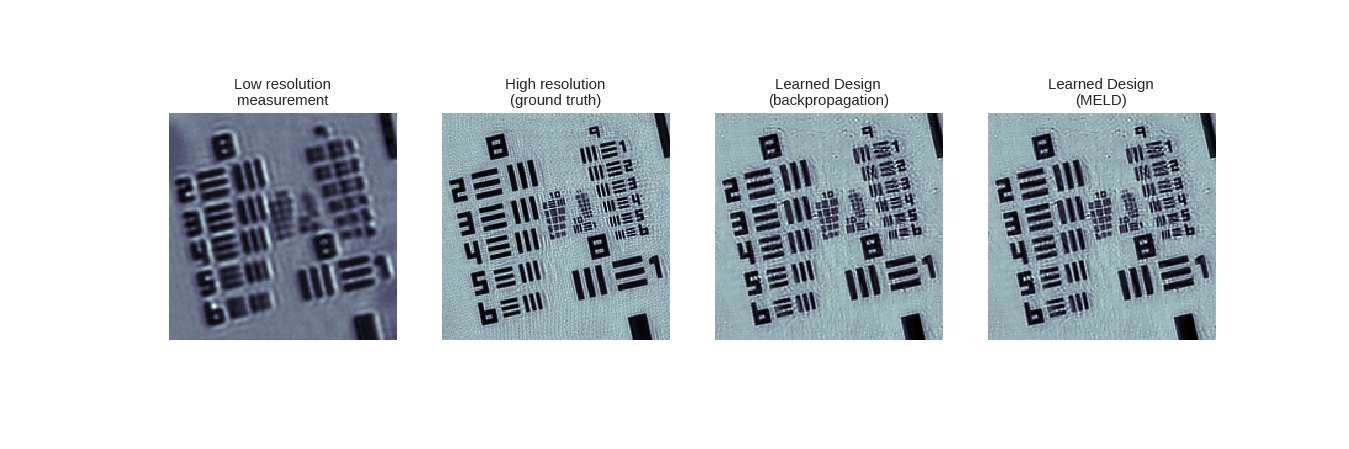

learning_comparison_1_7_100_0.40.pdf


In [15]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import matplotlib as mpl
mpl.rc('image', cmap='bone')

view = lambda x : x[::-1][38:223,35:220]

vmin = np.min(x_single_abs)
vmax = np.max(x_single_abs)

plt.figure(figsize=(15,5))

plt.subplot(141)
img = up_img_list[0,:,:]
scaled_img = img * (np.min(img)/np.max(img))*(vmax/vmin) + vmin
plt.imshow(view(scaled_img))
plt.title('Low resolution\nmeasurement')
plt.axis('off')

plt.subplot(142)
plt.imshow(view(x_single_abs), vmin=vmin, vmax=vmax)
plt.title('High resolution\n(ground truth)')
plt.axis('off')

plt.subplot(143)
plt.imshow(view(x_bp_abs_np), vmin=vmin, vmax=vmax)
plt.title('Learned Design\n(backpropagation)')
plt.axis('off')

plt.subplot(144)
plt.imshow(view(x_meld_abs_np), vmin=vmin, vmax=vmax)
plt.title('Learned Design\n(MELD)')
plt.axis('off')

exp_output = 'learning_comparison_{0:d}_{1:d}_{2:d}_{3:.2f}.pdf'.format(checkpoint['num_bf'], checkpoint['num_df'], checkpoint['num_unrolls'], checkpoint['alpha'])
print(exp_output)
plt.savefig(exp_output, dpi=200, transparent=True)

<IPython.core.display.Javascript object>


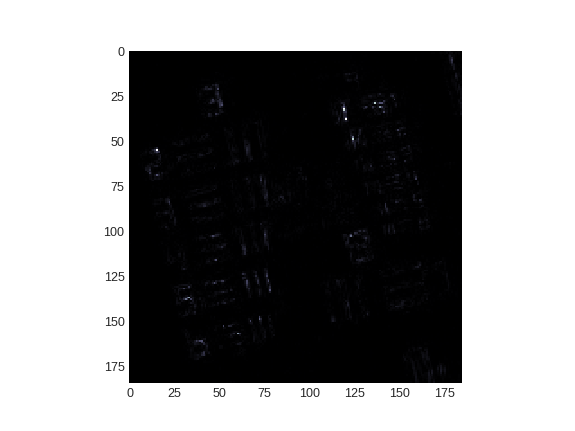

In [16]:
plt.figure()
plt.imshow(100*np.abs(view(x_bp_abs_np) - view(x_meld_abs_np))/view(x_meld_abs_np),vmin=0,vmax=100)

# Reading loss files

In [19]:
import json
path = './run-11_00_55_batch_size=5_stepsize=0.003_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.400_num_df=7_num_bf=1_num_leds=89_meld=True-tag-Loss_test.json'
with open(path) as json_file:
    loss_meld = np.asarray(json.load(json_file))
path = './run-11_00_29_batch_size=5_stepsize=0.003_loss_fn=mse_optim=adam_num_unrolls=100_alpha=0.400_num_df=7_num_bf=1_num_leds=89_meld=False-tag-Loss_test.json'
with open(path) as json_file:
    loss_bp = np.asarray(json.load(json_file))

<IPython.core.display.Javascript object>


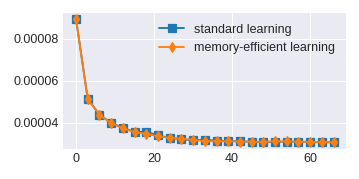

67


/home/kellman/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [20]:
plt.figure(figsize=(4,2))
learning_iter = loss_bp.shape[0]
print(learning_iter)
x = np.linspace(0,learning_iter-1,learning_iter)
Nskip = 3
plt.plot(x[::Nskip],loss_bp[::Nskip,2],'C0s-',label='standard learning')
plt.plot(x[::Nskip],loss_meld[::Nskip,2],'C1d-',label='memory-efficient learning')
plt.legend()
plt.grid('on')

plt.tight_layout()
exp_output = 'loss_comparison_{0:d}_{1:d}_{2:d}_{3:.2f}.pdf'.format(checkpoint['num_bf'], checkpoint['num_df'], checkpoint['num_unrolls'], checkpoint['alpha'])
plt.savefig(exp_output, dpi=300)